In [135]:
import numpy as np
import matplotlib.pyplot as plt

def generar_muestra(a, sigma, cantidad_puntos=20):
    x = np.random.rand(cantidad_puntos)
    y = a*x + np.random.normal(loc=0, scale=sigma, size=cantidad_puntos)

    return x, y


def regresion_lineal(x, y):
    n = len(x)
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_x2 = np.sum(x**2)
    sum_xy = np.sum(x*y)
    
    a_hat = (n * sum_xy - sum_x * sum_y) / (n * sum_x2 - sum_x ** 2)
    b_hat = (sum_y - a_hat * sum_x) / n
    
    return a_hat, b_hat

# Para poder definir el mapa de Monge necesitamos saber b, ¿La gracia no es estimar b sabiendo un estimador para a?

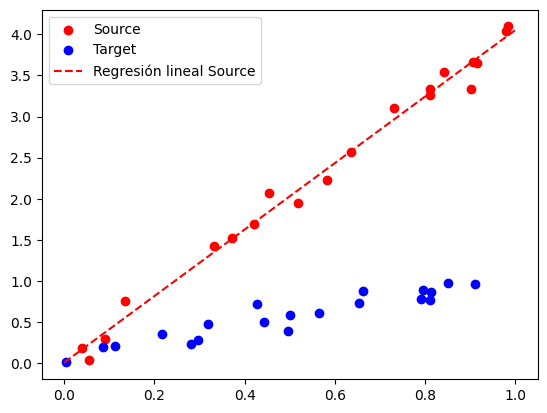

In [133]:
a = 4
b = 1
sigma_S = .1
sigma_T = .1
xS, yS = generar_muestra(a, sigma_S)
xT, yT = generar_muestra(b, sigma_T)

# Regresion lineal en Source
a_hat, b_hat = regresion_lineal(xS, yS)

x = np.linspace(0, 1, 2)
estimacion = a_hat*x + b_hat


plt.scatter(xS, yS, color="red", label="Source")
plt.scatter(xT, yT, color="blue", label="Target")
plt.plot(estimacion, "r--", label="Regresión lineal Source")
plt.plot()
plt.legend()

La función ```regresion_lieal``` calcula el estimador MLE de los coeficientes de la recta. Para esto suponemos que los datos siguen un modelo lineal de la forma $y[n] = a x[n] + w[n]$ donde $w \sim \mathcal{N}(0, \sigma)$ y $n$ varia entre $0$ y algún entero $N$. Poniendo supraindices $S$ y $T$ para representar el estimador de los datos Source y Target respectivamente, tenemos que

$$ 
\hat{a^S}_{MLE} \sim \mathcal{N} \Big(a^S, \frac{\sigma_s^2}{\sum x^S[n]}\Big) \hspace{1 cm} \text{y} \hspace{1 cm}\hat{a^T}_{MLE} \sim \mathcal{N} \Big(a^S, \frac{\sigma_s^2}{\sum x^T[n]}\Big).
$$

Luego, la solución al problema de Kantorovich entre dos Gaussianas multidimensionales tiene una forma cerrada: Si $X \sim \mathcal{a, A}$ y $Y \sim \mathcal{N}(b, B)$ entonces el transporte óptimo es
$$ 
T(x) = A^{- \frac{1}{2}} \Big(A^{\frac{1}{2}} B A^{\frac{1}{2}} \Big)^{\frac{1}{2}}A^{-\frac{1}{2}}(x-a) + b,
$$
lo cual en nuestro caso se reduce a 
$$ 
T(x) = \frac{\sigma_T}{\sigma_S}(x-a) + b.
$$


A partir del transporte óptimo y la pendiente $\hat{a}_{MLE}$ podemos estimar la pendiente para el conjunto Target, que será $\hat{a^T}_{MLE} = T(\hat{a^S}_{MLE})$.

In [136]:
def transporte_optimo(x, a, b, sigma_S, sigma_T):

    return (sigma_T / sigma_S)*(x-a) + b

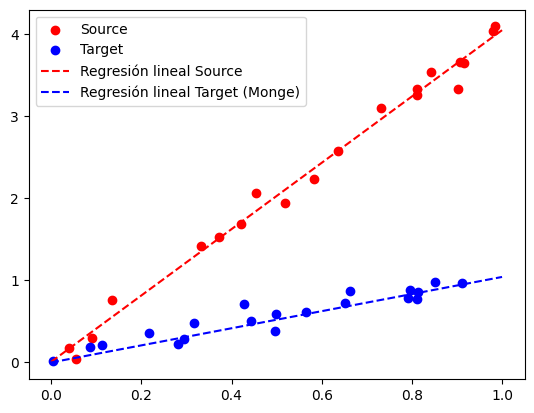

In [138]:
# Estimación de b_hat a partir de a_hat y el transporte óptimo
T_hat_a = transporte_optimo(a_hat, a, b, sigma_S, sigma_T)

x_T = np.linspace(0, 1, 2)
estimacion_T = T_hat_a*x_T 

plt.scatter(xS, yS, color="red", label="Source")
plt.scatter(xT, yT, color="blue", label="Target")
plt.plot(estimacion, "r--", label="Regresión lineal Source")
plt.plot(estimacion_T, "b--", label="Regresión lineal Target (Monge)")

plt.plot()
plt.legend()

---
---

### Otra opción más viable: Simular muchas muestras de source y pocas de Target. Encontrar el transporte óptimo entre Source y Target. Transportar Source y calcular la regresión lineal en estos datos transportados. Luego usar esta regresión para estiamr el Target.

---
---

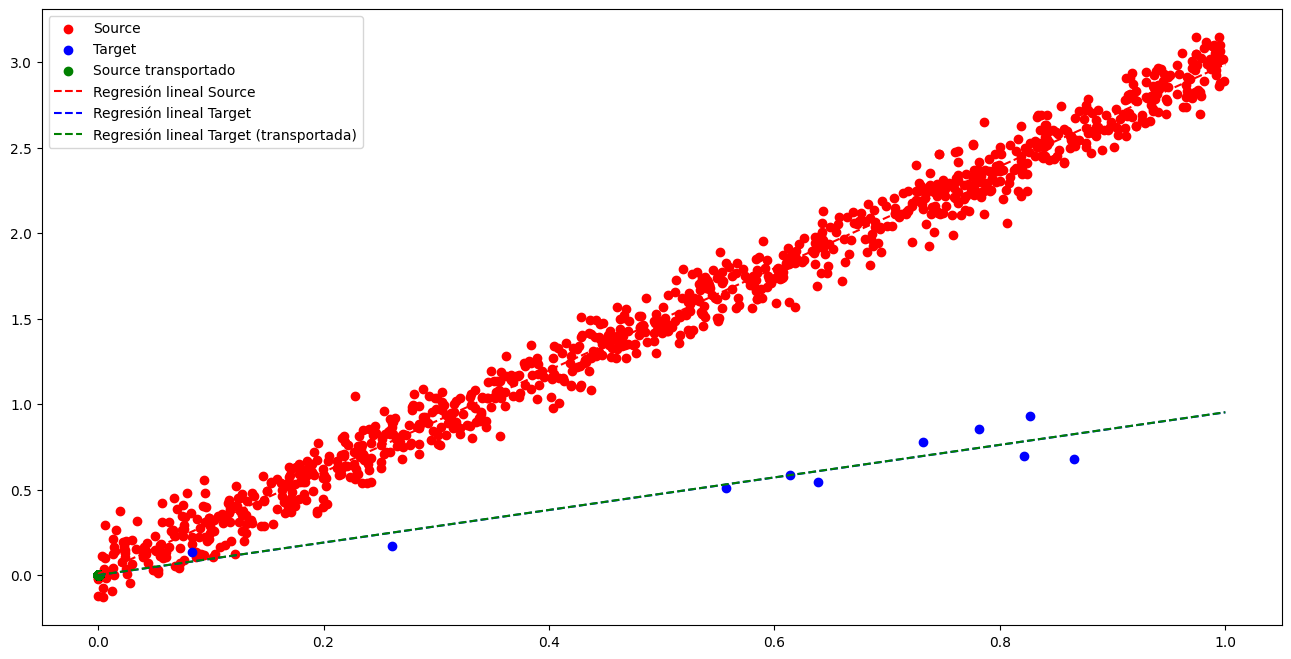

In [163]:
import ot
from scipy.spatial.distance import cdist


a = 3
b = 1
sigma_S = .1
sigma_T = .1
xS, yS = generar_muestra(a, sigma_S, cantidad_puntos=1000)
xT, yT = generar_muestra(b, sigma_T, cantidad_puntos=10)


x = np.linspace(0, 1, 2)

# Regresión lineal en Source
aS_hat, bS_hat = regresion_lineal(xS, yS)
estimacion_source = aS_hat*x + bS_hat

# Regresión lineal en Target
aT_hat, bT_hat = regresion_lineal(xT, yT)
estimacion_target = aT_hat*x + bT_hat


# Transporte óptimo
Xs = np.vstack((xS, yS)).T
Xt = np.vstack((xT, yT)).T
# Matriz de costo
C = cdist(Xs, Xt, 'euclidean')

# Suponemos una densidad uniforme en los puntos
densidad_S = np.ones(Xs.shape[0]) / Xs.shape[0]
densidad_T = np.ones(Xt.shape[0]) / Xt.shape[0]

# Solución al problema de Kantorovich
transporte = ot.emd(densidad_S, densidad_T, C)


# Transportamos el source
Xs_transportado = np.dot(transporte, Xt)

a_traspontado, b_transportado = regresion_lineal(Xs_transportado[:, 0], Xs_transportado[:, 1])

x = np.linspace(0, 1, 2)
estimacion_transportada = a_traspontado*x + b_transportado

plt.figure(figsize=(16, 8))
plt.scatter(xS, yS, color="red", label="Source")
plt.scatter(xT, yT, color="blue", label="Target")
plt.scatter(Xs_transportado[:, 0], Xs_transportado[:, 1], color="green", label="Source transportado")
plt.plot(estimacion_source, "r--", label="Regresión lineal Source")
plt.plot(estimacion_target, "b--", label="Regresión lineal Target")
plt.plot(estimacion_transportada, "g--", label="Regresión lineal Target (transportada)")
plt.plot()
plt.legend()